# Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance
*presented at: 2017 IEEE PVSC-44*
*by: Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball*

## Introduction
Predicting irradiance is crucial for developing solar power systems. Clear sky models are used to predict irradiance based on solar position and atmospheric data. This paper compares clear sky predictions using atmospheric data from ECMWF with irradiance measurments from SURFRAD. This notebook presents the analysis for the paper and presentation given by the authors at the 2017 IEEE PVSC-44 in Washingtion DC June 25-30th.

## Data
Two sources of data are used in this analysis, SURFRAD and ECMWF, each described in the following sections.

### SURFRAD
SURFRAD data from NOAA contains irradiance measurements at sub-hour increments from seven sites accross the United States. The data can be viewed online or downloaded from a NOAA FTP site <ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/>. Data is organized folders for each site and yearly subfolders containing individual daily files. The `README` in each site folder provides additional information such as the format of the files, types of data in each column and definitions of abbreviations. The first two rows of each daily file contains header information about the file. The first line is the station name and the second line contains the latitude, longitude and elevation.

|station id |tz    |station name  |latitude |longitude |elevation |
|-----------|------|--------------|---------|----------|----------|
|bon        |-6.0  |     Bondville|    40.05|    -88.37|       213|
|tbl        |-7.0  |Table Mountain|    40.13|   -105.24|      1689|
|dra        |-8.0  |   Desert Rock|    36.62|   -116.02|      1007|
|fpk        |-7.0  |     Fort Peck|    48.31|   -105.10|       634|
|gwn        |-6.0  | Goodwin Creek|    34.25|    -89.87|        98|
|psu        |-5.0  |    Penn State|    40.72|    -77.93|       376|
|sxf        |-6.0  |   Sioux Falls|    43.73|    -96.62|       473|

### ECMWF
The European Center for Medium Weather Forecast hosts datasets for the EU Copernicus MACC clearsky model. This data set contains aerosol optical depth and total column water vapor data derived from ground measurments and satelite data for the entire globe from 2003 to 2012.


In [1]:
# imports and settings
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import seaborn as sns

from pvsc44_clearsky_aod import ecmwf_macc_tools

%matplotlib inline

sns.set_context('notebook', rc={'figure.figsize': (16, 8)})

In [2]:
# get the "metadata" that contains the timezone, latitude, longitude, elevation and station id for SURFRAD
METADATA = pd.read_csv('metadata.csv', index_col=0)

In [3]:
# get SURFRAD data
DATADIR = 'surfrad'  # folder where SURFRAD data is stored relative to this file
NA_VAL = '-9999.9'  # value SURFRAD uses for missing data
USECOLS = [0, 6, 7, 8, 9, 10, 11, 12]  # omit 1:year, 2:month, 3:day, 4:hour, 5:minute and 13:jday columns
# read 2003 data for Bondville, IL
bon = pd.read_csv(
    os.path.join(DATADIR, 'bon03.csv'),
    index_col=0,
    usecols=[0, 6, 7, 8, 9, 10, 11, 12],
    na_values=NA_VAL)
# append the data from 2003 to 2012 which coincides with the ECMWF data available
for y in xrange(2004, 2013):
    bon = bon.append(pd.read_csv(
        os.path.join(DATADIR, 'bon%s.csv' % str(y)[-2:]),
        index_col=0,
        usecols=[0, 6, 7, 8, 9, 10, 11, 12],
        na_values=NA_VAL
    ))
bon.index.rename('timestamps', inplace=True)
#bon_dt = np.diff(np.array(bon.index, dtype='datetime64[m]'))

In [11]:
# get AOD and water vapor for the Bondville, IL site.
ATMOS = ecmwf_macc_tools.Atmosphere()
bon_atm = pd.DataFrame(
    ATMOS.get_all_data(METADATA['latitude']['bon'], METADATA['longitude']['bon']),
    index=pd.DatetimeIndex(start='2003-01-01T00:00:00', freq='3H', end='2012-12-31T23:59:59')
)

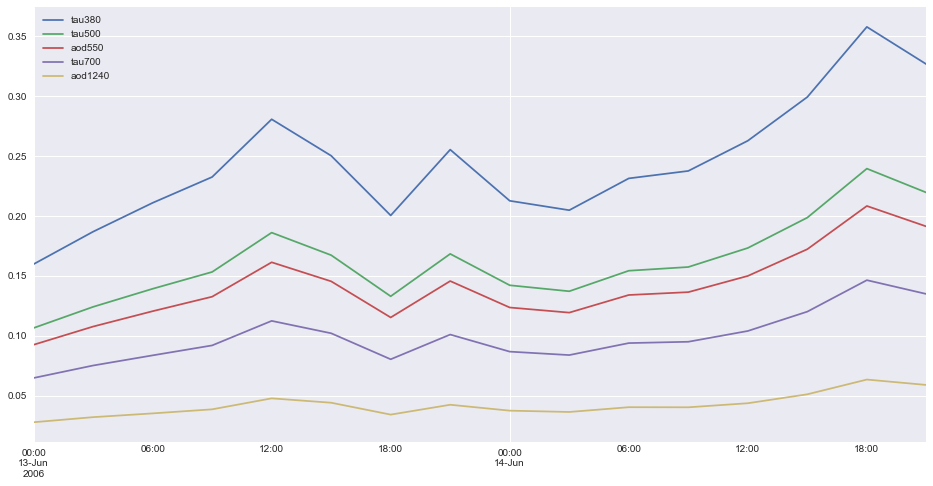

In [19]:
bon_atm[['tau380', 'tau500', 'aod550', 'tau700', 'aod1240']]['2006-06-13':'2006-06-14'].plot()

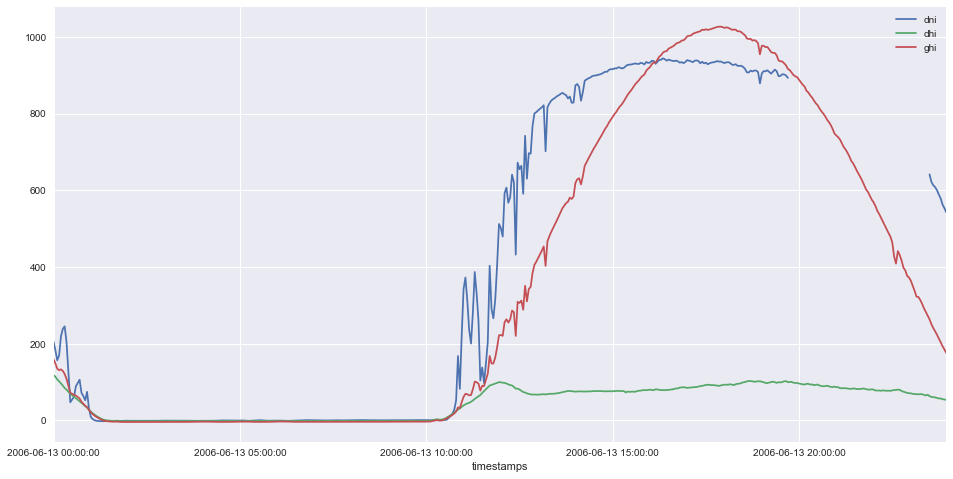

In [20]:
bon[['dni', 'dhi', 'ghi']]['2006-06-13':'2006-06-14'].plot()

In [9]:
bon_atm2

,alpha,aod1240,aod550,pwat,tau380,tau500,tau700,tcwv
2003-01-01 00:00:00,1.518696,0.021356,0.073402,0.454516,0.128701,0.084835,0.050892,4.545164
2003-01-01 03:00:00,1.568469,0.014806,0.052991,0.540636,0.094639,0.061536,0.036302,5.406360
2003-01-01 06:00:00,1.525676,0.012328,0.042613,0.680223,0.074909,0.049282,0.029495,6.802234
2003-01-01 09:00:00,1.455449,0.012416,0.040537,0.921304,0.069433,0.046569,0.028538,9.213040
2003-01-01 12:00:00,1.478917,0.011974,0.039845,1.004975,0.068843,0.045877,0.027892,10.049748
2003-01-01 15:00:00,1.502257,0.011443,0.038807,0.918583,0.067631,0.044781,0.027013,9.185830
2003-01-01 18:00:00,1.493931,0.012239,0.041229,0.818450,0.071630,0.047538,0.028757,8.184502
2003-01-01 21:00:00,1.491596,0.014629,0.049186,0.710971,0.085381,0.056700,0.034326,7.109707
2003-01-02 00:00:00,1.463729,0.020648,0.067867,0.896543,0.116601,0.078027,0.047682,8.965429
2003-01-02 03:00:00,1.441735,0.024985,0.080667,1.096128,0.137471,0.092550,0.056977,10.961283


![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)
Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance by [Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball](https://github.com/mikofski/pvsc44-clearsky-aod) is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).
